In [1]:
import itertools
import pathlib
import pyam # version: 1.4.1.dev15+g3563b43

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

In [2]:
# utils.py
def make_gap_data(df, v):
    x = (
        df
        .filter(variable=v, year=[2030])
        .filter(Category=categories_to_temp.keys())
        .as_pandas()
        .replace({'Category': categories_to_temp})
    )
    idx = ['model', 'scenario', 'region', 'year', 'Category']
    x = x.set_index(idx)['value'] 
    return x

def make_gap_plot(data, drop={}, ax=None):
    data = data.reset_index().dropna()
    for col, value in drop.items():
        data = data[data[col] != value]
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    ax.axhline(0, c='k', ls='--', alpha=0.5)
    sns.boxplot(
        x="region", y="value", hue="Category",
        data=data, 
        palette="Set2_r", ax=ax, showfliers=False, whis=0,
    )
    return ax

# Load Data

In [3]:
data_path = pathlib.Path('../data')

In [4]:
LABEL = '2015_soft_grassi'

In [5]:
pddata = pd.read_csv(data_path / f'analysis_{LABEL}_data.csv')

In [6]:
df = pyam.IamDataFrame(pddata)
df.load_meta(data_path / f'analysis_{LABEL}_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators


In [7]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

# Figure 2A

In [8]:
variables = [
    'Emissions|Kyoto Gases - Reanalyzed and Adjusted',
]
quantiles = (0.1, 0.25, 0.5, 0.75, 0.9)

data = pyam.concat([
    (
        df
        .filter(region='World', variable=variable, year=range(2015, 2101))
        .filter(Category=category)
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .quantiles(quantiles)
        .rename(model={'unweighted': temp})
    ) for (category, temp), variable in itertools.product(categories_to_temp.items(), variables)
])

for variable in variables:
    data.append(
        df
        .filter(region='World', variable=variable, year=range(2015, 2101))
        .filter(Policy_category_name='P1b: Current policies')
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .quantiles(quantiles)
        .rename(model={'unweighted': 'Current Policies'}),
        inplace=True
    )

In [9]:
targets = pd.DataFrame([
    ('Current Policies (den Elzen 2022)', 56.826, 52.592, 59.552, 'dimgrey', 0),
    ('Conditional NDCs (den Elzen 2022)', 50.700, 48.542, 52.202, 'plum', -0.35),
    ('Unconditional NDCs (den Elzen 2022)', 52.284, 50.059, 54.136, 'thistle', 0.35),
], columns=['label', 'med', 'min', 'max', 'color', 'jitter'])
lulucf_offset = 5.5

Text(0.5, 0, '')

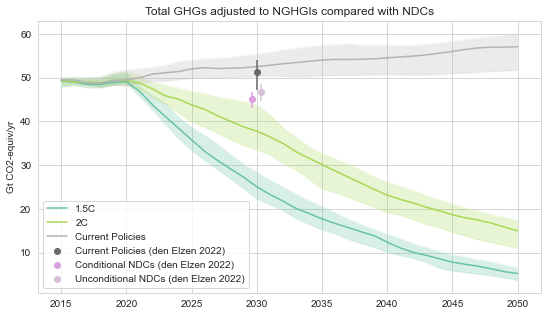

In [10]:
fig, ax = plt.subplots(figsize=(9, 5))
(
    data
    .filter(variable='Emissions|Kyoto Gases - Reanalyzed and Adjusted', year=range(1990, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, cmap='Set2', alpha=0.1)
)
(
    data
    .filter(variable='Emissions|Kyoto Gases - Reanalyzed and Adjusted', year=range(1990, 2051))
    .filter(scenario='quantile_0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - lulucf_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - lulucf_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')

# Figure 2B

In [11]:
# change in emissions in negative, gap is positive
adj = make_gap_data(df, 'Change in Emissions|Kyoto Gases - Reanalyzed and Adjusted from 2020') * -1 
orig = make_gap_data(df, 'Change in Emissions|Kyoto Gases - Reanalyzed from 2020') * -1

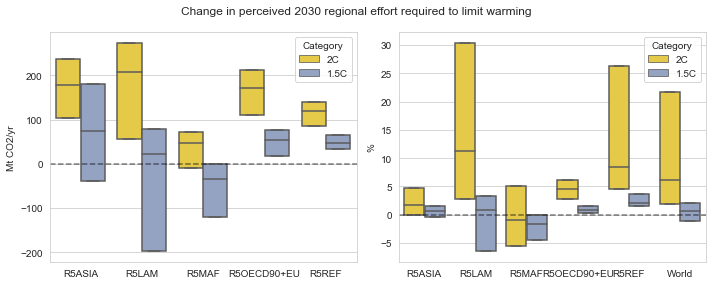

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax = axs[0]
make_gap_plot(adj-orig, drop={'region': 'World'}, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Mt CO2/yr')

ax = axs[1]
make_gap_plot(100 * ((adj / orig) - 1), ax=ax)
ax.set_xlabel('')
ax.set_ylabel('%')

fig.suptitle(f'Change in perceived 2030 regional effort required to limit warming')
plt.tight_layout()